In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from Utils import *
from numpy import nan
from scipy.interpolate import griddata
import scipy.interpolate as interp
from scipy.interpolate import LinearNDInterpolator

In [35]:
# S&P 500 CUSIP: 64881510

#data = pd.read_csv('data/APPL_vol_surface.csv')

#SELECT YOUR DATA HERE
data = pd.read_csv('data/SPX_vol_surface_FULL.csv')

In [36]:
data

,secid,date,days,delta,impl_volatility,impl_strike,impl_premium,dispersion,cp_flag,cusip,ticker,index_flag
0,108105,19960104,10,-90,NaN,0.000,0.0000,NaN,P,64881510,SPX,1
1,108105,19960104,10,-85,NaN,0.000,0.0000,NaN,P,64881510,SPX,1
2,108105,19960104,10,-80,NaN,0.000,0.0000,NaN,P,64881510,SPX,1
3,108105,19960104,10,-75,NaN,0.000,0.0000,NaN,P,64881510,SPX,1
4,108105,19960104,10,-70,NaN,0.000,0.0000,NaN,P,64881510,SPX,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2447825,108105,20211231,730,70,0.250166,4117.904,963.0674,0.021641,C,64881510,SPX,1
2447826,108105,20211231,730,75,0.265997,3860.017,1151.8750,0.025721,C,64881510,SPX,1
2447827,108105,20211231,730,80,0.283967,3558.327,1383.1930,0.031471,C,64881510,SPX,1
2447828,108105,20211231,730,85,0.303781,3196.287,1672.4860,0.039406,C,64881510,SPX,1


In [37]:
max_ivol = data.impl_volatility.max()

In [38]:
print("Max Implied Volatility in dataset:", max_ivol)

Max Implied Volatility in dataset: 1.282831


In [39]:
unique_dates = data.date.unique()
unique_deltas = data.delta.unique()
unique_tenors = data.days.unique()

In [40]:
#data = data.loc[data.cp_flag == 'C']

filtered_data = data.loc[data.date == unique_dates[1]]

x = filtered_data.days
y = filtered_data.delta
z = filtered_data.impl_volatility

#### For the record, call options have positive delta, and put options have negative delta. The ridge in the middle is where data from calls is joined with data from puts, as we go from a positive delta to a negative delta.

Text(0.5, 0, 'implied vol')

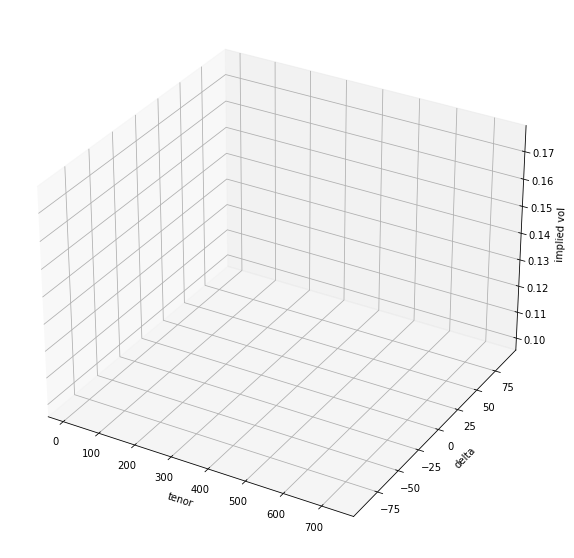

In [41]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(x, y, z,
                cmap='viridis', edgecolor='none');

ax.set_xlabel('tenor')
ax.set_ylabel('delta')
ax.set_zlabel('implied vol')

## Process data into a matrix... to plug into a CNN and skip the visualization step

In [42]:
num_dates = unique_dates.shape[0]
num_deltas = unique_deltas.shape[0]
num_tenors = unique_tenors.shape[0]

print("Unique Dates:", num_dates)
print("Unique Deltas:", num_deltas)
print("Unique Tenors:", num_tenors)

Unique Dates: 6545
Unique Deltas: 34
Unique Tenors: 11


In [43]:
data.head(10)

,secid,date,days,delta,impl_volatility,impl_strike,impl_premium,dispersion,cp_flag,cusip,ticker,index_flag
0,108105,19960104,10,-90,NaN,0.0,0.0,NaN,P,64881510,SPX,1
1,108105,19960104,10,-85,NaN,0.0,0.0,NaN,P,64881510,SPX,1
2,108105,19960104,10,-80,NaN,0.0,0.0,NaN,P,64881510,SPX,1
3,108105,19960104,10,-75,NaN,0.0,0.0,NaN,P,64881510,SPX,1
4,108105,19960104,10,-70,NaN,0.0,0.0,NaN,P,64881510,SPX,1
5,108105,19960104,10,-65,NaN,0.0,0.0,NaN,P,64881510,SPX,1
6,108105,19960104,10,-60,NaN,0.0,0.0,NaN,P,64881510,SPX,1
7,108105,19960104,10,-55,NaN,0.0,0.0,NaN,P,64881510,SPX,1
8,108105,19960104,10,-50,NaN,0.0,0.0,NaN,P,64881510,SPX,1
9,108105,19960104,10,-45,NaN,0.0,0.0,NaN,P,64881510,SPX,1


In [44]:
# Shape: (num_dates, num_tenors, num_deltas)
vol_surface_matrix = data.set_index(
    ["date", "days", "delta"]).impl_volatility.unstack().values.reshape(
    num_dates, num_tenors, num_deltas)

In [48]:
vol_surface_matrix.transpose(0,2,1).shape

(6545, 34, 11)

# Scale to 0-255 values

In [53]:
vol_surface_matrix /= (255/max_ivol)

In [49]:
dates = pd.to_datetime(unique_dates, format='%Y%m%d')
dates

DatetimeIndex(['1996-01-04', '1996-01-05', '1996-01-08', '1996-01-09',
               '1996-01-10', '1996-01-11', '1996-01-12', '1996-01-15',
               '1996-01-16', '1996-01-17',
               ...
               '2021-12-17', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=6545, freq=None)

In [98]:
#Data is stored in a pandas dataframe with multiindex. df.loc[date] will give the 2d surface with tenors
#in columns and deltas in rows

midx = pd.MultiIndex.from_product([dates, unique_deltas])

data = pd.DataFrame(index = midx, columns = unique_tenors, dtype='float')
for i in range(len(dates)):
    data.loc[dates[i]] = vol_surface_matrix[i].T

In [99]:
data = data.interpolate(method = "linear", order = 1, limit_direction = "both")

In [101]:
data = data.dropna()

In [104]:
data.to_csv('processed_data/SPX.csv')